In [1]:
import qdpm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pywt

# I Calibration

In [2]:
I_get_gain = qdpm.Experiment(r"O:\68707\BF2222\LABVIEWdata\Cooldown20210114\Heterodyne\Nb_SWIPHT_MB_W8_180nm\IQ Calib\Q1\I\2021_01_17_14_19_15_get_gain")

In [3]:
qubit_idx = 0

In [20]:
clf_getI = qdpm.SingleQubitClassifier(I_get_gain, qubit=qubit_idx)
prediction_getI = clf_getI.predict()
population_getI = 1-prediction_getI.mean(axis=1)

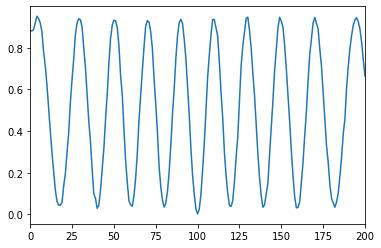

In [21]:
fig, ax = plt.subplots()
ax.plot(I_get_gain.scan_value[0], population_getI)
ax.set_xlim(I_get_gain.scan_value[0][0], I_get_gain.scan_value[0][-1])
plt.show()

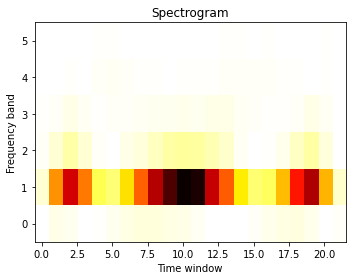

In [37]:
from scipy.signal import spectrogram
freqs, times, spectrogram = spectrogram(population_getI, fs=100, nperseg=10)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
# plt.ylim(9, 18)
plt.tight_layout()

In [30]:
times

array([1.005])

In [10]:
angle_calib_exp = qdpm.Experiment(r"O:\68707\BF2222\LABVIEWdata\Cooldown20210114\Heterodyne\Nb_SWIPHT_MB_W8_180nm\IQ Calib\Q2\45 degree RabiAmp for angle error\2021_03_01_21_27_04")

In [11]:
qubit_idx = 1

In [12]:
segment_length = int(angle_calib_exp.scan_size[0]/3)
APS_amp = np.linspace(0, 0.6, segment_length)

In [13]:
clf = qdpm.SingleQubitClassifier(angle_calib_exp, qubit=qubit_idx)
prediction = clf.predict()
population = prediction.mean(axis=1)

In [14]:
def rabi_amp(x, a, f, c):
    return -a*np.cos(f*x)+c

In [21]:
popt_I, pcov_I = curve_fit(rabi_amp, APS_amp, population[:segment_length], p0=[0.4, 2*np.pi*3, 0.5])
popt_Q, pcov_Q = curve_fit(rabi_amp, APS_amp, population[segment_length:2*segment_length:], p0=[0.4, 2*np.pi*3, 0.5])
popt_45, pcov_45 = curve_fit(rabi_amp, APS_amp, population[2*segment_length:], p0=[0.4, 2*np.pi*4, 0.5])

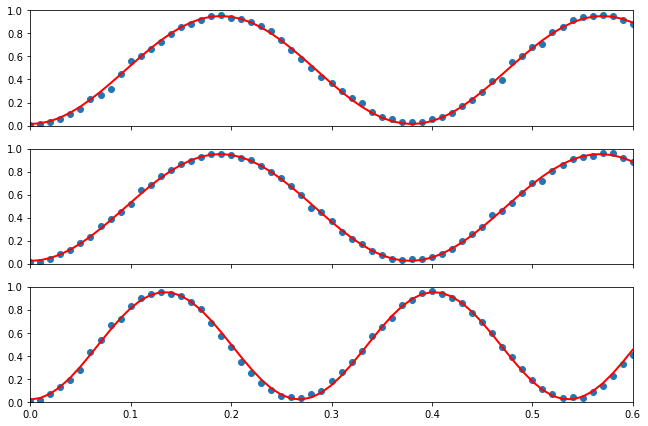

In [22]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10.8, 7.2))

ax[0].plot(APS_amp, rabi_amp(APS_amp, *popt_I), 'r', linewidth=2)
ax[0].scatter(APS_amp, population[:segment_length])

ax[1].plot(APS_amp, rabi_amp(APS_amp, *popt_Q), 'r', linewidth=2)
ax[1].scatter(APS_amp, population[segment_length:2*segment_length:])

ax[2].plot(APS_amp, rabi_amp(APS_amp, *popt_45), 'r', linewidth=2)
ax[2].scatter(APS_amp, population[2*segment_length::])

for i in range(3):
    ax[i].set_xlim([0, 0.6])
    ax[i].set_ylim([0, 1])
plt.show()

In [23]:
ampIQ = np.mean([popt_I[1], popt_Q[1]])
print(f'IQ Imbalance: {popt_I[1]/popt_Q[1]:.4f}\nAngle error in degree: {np.degrees(np.arcsin(popt_45[1]**2/(2*ampIQ**2)-1)):.4f}')

IQ Imbalance: 0.9958
Angle error in degree: -0.0030
